# Project: What Makes a Champion #
##### aka how to win Football (or Soccer... as you prefer!) Championships

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#sources">Sources</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Analyzing the Performances</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

This project aims at understanding what makes the difference between a team who reaches the top results and a team which has always performed as a _not-so-impressive_ level of performances (and, sometimes, even worse than that).

Football/Soccer allows to earn points when you tie a match (so victory is not exactly a weekly obsession, sometimes a tie match can be considered as a victory too) but earning 3 points per win does not make a tie match a good result on a large scale and defeats... well, those are even worse!

So, why Cagliari has never won a championship between the seasons 2008/2009 and 2014/2015 and how bad did they perform compared to the so called *Campioni d'Italia*?
What were the key performances which most negatively influenced Cagliari's performances or eased the victory to the other teams?

<a id='sources'></a>
## Sources ##

The database was available <a href='https://d17h27t6h515a5.cloudfront.net/topher/2017/November/5a0a4cad_database/database.sqlite'>here</a>

Data about the Serie A championship can be found here

*    http://www.legaseriea.it/it/serie-a/squadre/cagliari/storia
    
*    http://www.legaseriea.it/it/serie-a/albo-d-oro

<a id="wrangling"></a>

## Data Wrangling ##

#### General Properties

There is a first main difference from what we have seen in the previous Case Studies: the data is stored in a SQLite database.

This means that there will be a different way to access data and that data is structured in tables which have relations and that can be joined to ease the access to more detailed information.

First of all, in order to access data, after the usual import of _pandas_, _numpy_, _matplotlib.pyplot_ and _seaborn_ libraries, I need to import the _sqlite3_ library and define a variable which stores the database file's name and create a variable which will store the necessary data for the database connection (that I will pass to the *pd.read_sql* instruction, through which I will perform SQL queries

In [1]:
# Libraries Import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# in order to show plots within this notebook
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")


 # to import data, which is stored in a sqlite3 database
import sqlite3

# database file's name
database = 'soccer_database.sqlite'

from IPython.display import Image
logo = Image(filename='cagliari_calcio.png')

The data within the database is stored in several tables, as follows

In [3]:
# opening a connection to the database
conn = sqlite3.connect(database)

tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


The tables with data that really interest this project are:

* *League*: descriptive data about all the Leagues

* *Match*: match details

* *Team*: team details

I start by querying the League table, in order to obtain the League ID for _Italy Serie A_.

In [3]:
leagues = pd.read_sql('SELECT * FROM league where name = \'Italy Serie A\' ', conn)
leagues

,id,country_id,name
0,10257,10257,Italy Serie A


This ID (_10257_) will help me query the Matches and focus only on that Championship.

I do this by filtering the _Match_ table for all the available matches played in _Serie A_

In [4]:
serie_a = pd.read_sql('SELECT * FROM Match WHERE league_id = 10257 '
                               ' ORDER BY season, date', conn)
serie_a.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,10264,10257,10257,2008/2009,1,2008-08-30 00:00:00,537639,9882,8636,1,...,1.95,4.0,3.1,1.85,4.33,3.0,1.9,4.20,3.0,1.83
1,10266,10257,10257,2008/2009,1,2008-08-30 00:00:00,537641,8600,8540,3,...,4.00,2.0,3.0,3.50,2.10,3.0,3.6,2.00,3.0,3.60
2,10257,10257,10257,2008/2009,1,2008-08-31 00:00:00,537632,8524,8551,1,...,4.33,2.0,3.0,3.50,2.00,3.0,4.0,1.83,3.0,4.20
3,10258,10257,10257,2008/2009,1,2008-08-31 00:00:00,537633,8529,8543,1,...,2.70,3.0,2.8,2.40,2.70,3.0,2.6,2.50,3.0,2.62
4,10259,10257,10257,2008/2009,1,2008-08-31 00:00:00,537634,8530,10233,1,...,3.40,2.3,3.0,3.00,2.40,2.9,3.0,2.30,3.0,2.88


In [6]:
serie_a.shape

(3017, 115)

The *serie_a.shape* shows that this dataframe has 115 columns and at first sight... they don't seem all necessary. I am interested in checking the overall results of the teams so, in order to keep the dataframe the most concise possible, I will drop all the columns about the League and the Country, players IDs and positioning on the pitch (those labeled like "home_player_X1" or "away_player_Y10") and the ones about betting odds.

In [5]:
cols_to_drop = serie_a.columns.get_loc('home_player_X1')
serie_a = serie_a.iloc[:, np.r_[0, 3:cols_to_drop]]
serie_a.head()

,id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
0,10264,2008/2009,1,2008-08-30 00:00:00,537639,9882,8636,1,1
1,10266,2008/2009,1,2008-08-30 00:00:00,537641,8600,8540,3,1
2,10257,2008/2009,1,2008-08-31 00:00:00,537632,8524,8551,1,0
3,10258,2008/2009,1,2008-08-31 00:00:00,537633,8529,8543,1,4
4,10259,2008/2009,1,2008-08-31 00:00:00,537634,8530,10233,1,0


Let's get some info about the dataframe (size, duplicated or null data)

In [8]:
serie_a.shape

(3017, 9)

In [12]:
# let's check datatypes for all the remaining fields
serie_a.dtypes

id                   int64
season              object
stage                int64
date                object
match_api_id         int64
home_team_api_id     int64
away_team_api_id     int64
home_team_goal       int64
away_team_goal       int64
dtype: object

In [11]:
type(serie_a['date'][0])

str

A first check on the fields datatypes shows that **date**s are represented as _strings_ and this is quite limiting (and requires extra work) in case we want to represent certain behaviours over time (for example, check whether there are times of the season when a team performs better/worse)

In [6]:
serie_a['date'] = pd.to_datetime(serie_a['date'])
serie_a.dtypes

id                           int64
season                      object
stage                        int64
date                datetime64[ns]
match_api_id                 int64
home_team_api_id             int64
away_team_api_id             int64
home_team_goal               int64
away_team_goal               int64
dtype: object

In [13]:
# check for duplicated rows
serie_a[serie_a.duplicated()].sum()

id                  0.0
season              0.0
stage               0.0
date                0.0
match_api_id        0.0
home_team_api_id    0.0
away_team_api_id    0.0
home_team_goal      0.0
away_team_goal      0.0
dtype: float64

In [17]:
serie_a.nunique()

id                  3017
season                 8
stage                 38
date                 723
match_api_id        3017
home_team_api_id      32
away_team_api_id      32
home_team_goal         8
away_team_goal         8
dtype: int64

It's confirmed that there are no duplicated matches: in fact, among all the 3017 rows, the only field showing all unique values is the **match_api_id** field

In [16]:
# count of null fields
serie_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3017 entries, 0 to 3016
Data columns (total 9 columns):
id                  3017 non-null int64
season              3017 non-null object
stage               3017 non-null int64
date                3017 non-null object
match_api_id        3017 non-null int64
home_team_api_id    3017 non-null int64
away_team_api_id    3017 non-null int64
home_team_goal      3017 non-null int64
away_team_goal      3017 non-null int64
dtypes: int64(7), object(2)
memory usage: 212.2+ KB


There are no null fields in the DataFrame, let's move further.

The seasons included in the Match database go from 2008/2009 to 2014/2015 and, as reported in the <a href="http://www.legaseriea.it/it/serie-a/albo-d-oro" target="_blank">Lega Serie A</a> Official website, the Championship winning teams have been:

* Inter (2008/2009 - 2009/2010)
* Milan (2010/2011)
* Juventus (from 2011/2012 to 2014/2015)

In order to access data about these teams (along with my favourite team's data, **Cagliari**), I need to get their *team_api_id* and *team_fifa_api_id* which are stored in the _Team_ table

In [11]:
teams_to_monitor = pd.read_sql('SELECT * FROM Team WHERE team_long_name = \'Inter\' OR team_long_name = \'Milan\' '
                        ' OR team_long_name = \'Juventus\' OR team_long_name = \'Cagliari\' ', conn)
teams_to_monitor

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,20515,8529,1842,Cagliari,CAG
1,20522,9885,45,Juventus,JUV
2,20523,8564,47,Milan,ACM
3,20528,8636,44,Inter,INT


In [7]:
# For a future use, I create teams id variables
cagliari_id = 8529
inter_id = 8636
milan_id = 8564
juventus_id = 9885

Now that I have the team IDs I can create a DataFrame which stores the matches for each of the teams. As mentioned before, 3 teams became **Campioni d'Italia** and for each of them I will only filter data according to the seasons they have won the Championship. About Cagliari, I will get all the available matches.

The _Match_ table's structure stores team IDs in the columns *home_team_api_id* and *away_team_api_id*: in order to have all the matches for each team, I have to filter whether the team appears as _Home_ or _Away_ team

In [8]:
cagliari_matches = serie_a.query('home_team_api_id == 8529 or away_team_api_id == 8529')
cagliari_matches.shape

(264, 9)

Let's do the same for the other teams

In [9]:
inter_matches = serie_a.query('(home_team_api_id == 8636 or away_team_api_id == 8636) and season in (\'2008/2009\', \'2009/2010\')')

milan_matches = serie_a.query('(home_team_api_id == 8564 or away_team_api_id == 8564) and season in (\'2010/2011\')')

juventus_matches = serie_a.query('(home_team_api_id == 9885 or away_team_api_id == 9885) and season in (\'2011/2012\', \'2012/2013\', \'2013/2014\', \'2014/2015\')')

In order to calculate Home and Away performances, we need to integrate the DataFrames we have for each team by adding a column where we'll explicit whether it's a Home or Away match and the points earned after that match (3 points for a victory, 1 point for a draw and 0 points for a loss).

To do so, I create a function which will split the matches between Home and Away and will determine the points earned by each team in every match

In [10]:
def matches_and_scores(team_matches, team_id):
    # list with all the H (home) or A (away) matches
    match_played = [] 
    # list with the scored for the team in that match (3 points for a win, 1 for a draw and 0 for a loss)
    score = []
    for index, row in team_matches.iterrows(): 
        if row['home_team_api_id'] == team_id: 
            match_played.append('H') 
            if row['home_team_goal'] > row['away_team_goal']:
                # home win
                score.append(3)
            elif row['home_team_goal'] == row['away_team_goal']:
                # draw match
                score.append(1)
            else:
                # home defeat
                score.append(0)
        else: 
            match_played.append('A') 
            if row['home_team_goal'] > row['away_team_goal']:
                # away defeat
                score.append(0)
            elif row['home_team_goal'] == row['away_team_goal']:
                # draw
                score.append(1)
            else:
                # away win
                score.append(3)
    return match_played, score

In order to add the two newly created columns to the originary structure of the DataFrame, i use pandas' *<a href='http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.assign.html' targe='_blank'>assign</a>* method

In [11]:
# Cagliari Matches
cagliari_match_stats = cagliari_matches.assign(home_away = matches_and_scores(cagliari_matches, cagliari_id)[0], score = matches_and_scores(cagliari_matches, cagliari_id)[1])
cagliari_match_stats.head()

# Cagliari's start was quite tough... 5 losses in the first 5 matches of the 2008/2009 season!

,id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_away,score
3,10258,2008/2009,1,2008-08-31,537633,8529,8543,1,4,H,0
13,10368,2008/2009,2,2008-09-14,539564,8551,8529,2,0,A,0
29,10486,2008/2009,3,2008-09-21,539582,8529,9885,0,1,H,0
39,10586,2008/2009,4,2008-09-24,539592,8524,8529,1,0,A,0
49,10596,2008/2009,5,2008-09-28,539602,9888,8529,2,0,A,0


I'll do the same to the other DataFrames

In [12]:
# Inter Matches 
inter_match_stats = inter_matches.assign(home_away = matches_and_scores(inter_matches, inter_id)[0], score = matches_and_scores(inter_matches, inter_id)[1])

# Milan Matches
milan_match_stats = milan_matches.assign(home_away = matches_and_scores(milan_matches, milan_id)[0], score = matches_and_scores(milan_matches, milan_id)[1])

# Juventus Matches
juventus_match_stats = juventus_matches.assign(home_away = matches_and_scores(juventus_matches, juventus_id)[0], score = matches_and_scores(juventus_matches, juventus_id)[1])

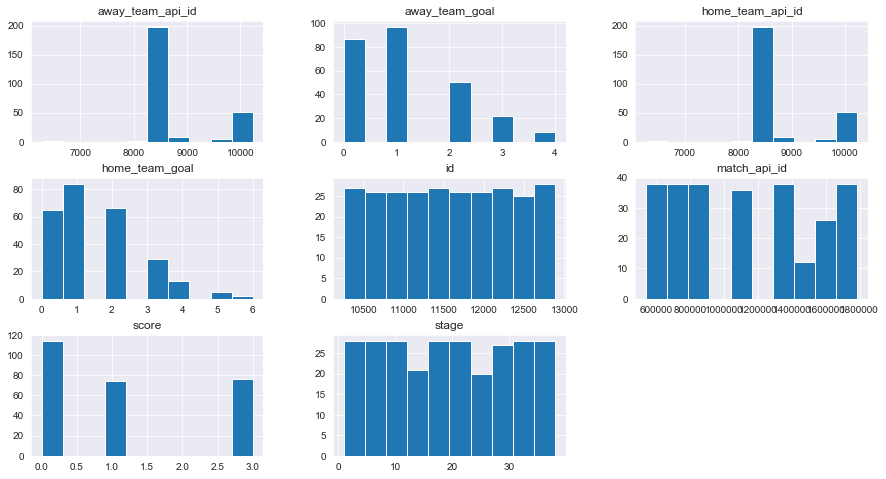

In [13]:
cagliari_match_stats.hist(figsize=(15,8));

Considering that fields like *away_team_api_id*, *home_team_api_id*, *id*, *match_api_id* are basically descriptive fields which don't measure anything, let's focus on the remaining fields.


For example, let's see how results (wins, draws, losses) are distributed in the Home and Away matches

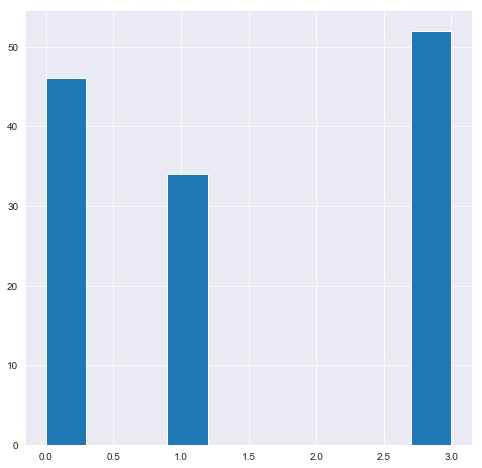

In [68]:
cagliari_match_stats[cagliari_match_stats['home_away'] == 'H']['score'].hist(figsize=(8,8));

# 0 = loss, 1 = draw, 3 = win Home Matches

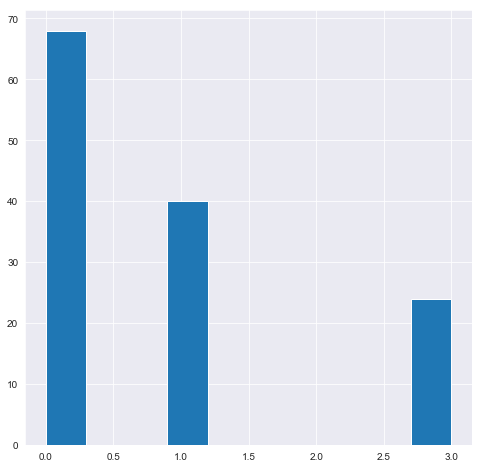

In [61]:
cagliari_match_stats[cagliari_match_stats['home_away'] == 'A']['score'].hist(figsize=(8,8));

# 0 = loss, 1 = draw, 3 = win Away Matches

Since matches are played Home and Away, we can already see that the best results for Cagliari have arrived in Home matches (Away matches are over 50% defeats). This will be interesting when (later) will be compared to winning teams performances.

Another important parameter to check in order to understand Cagliari's performances are goals. 

Again, Home matches record a higher number of goals (and a lower number of matches where Cagliari scored 0 goals, the team is usually more offensive when helped by the support of their fans).

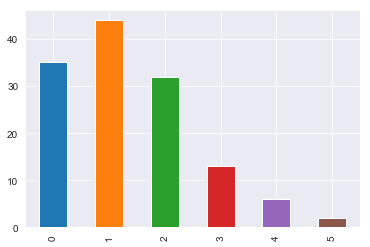

In [64]:
cagliari_match_stats[cagliari_match_stats['home_away'] == 'H']['home_team_goal'].value_counts().sort_index(0).plot(kind='bar');

# number of Home matches where Cagliari scored the amount of goals in X axis

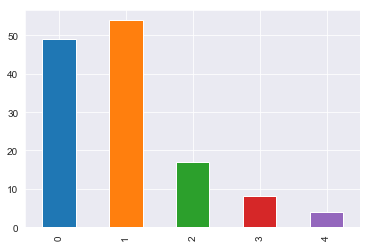

In [65]:
cagliari_match_stats[cagliari_match_stats['home_away'] == 'A']['away_team_goal'].value_counts().sort_index(0).plot(kind='bar');

# number of Away matches where Cagliari scored the amount of goals in X axis

These first assesments give us a hint about how better Cagliari performed in Home matches. But let's broaden this consideration by comparing *Cagliari* to *Campioni d'Italia*.

<a id='eda'></a>
## Analyzing the Performances

Let's start by comparing the total points at the end of each season

<Figure size 1044x756 with 0 Axes>

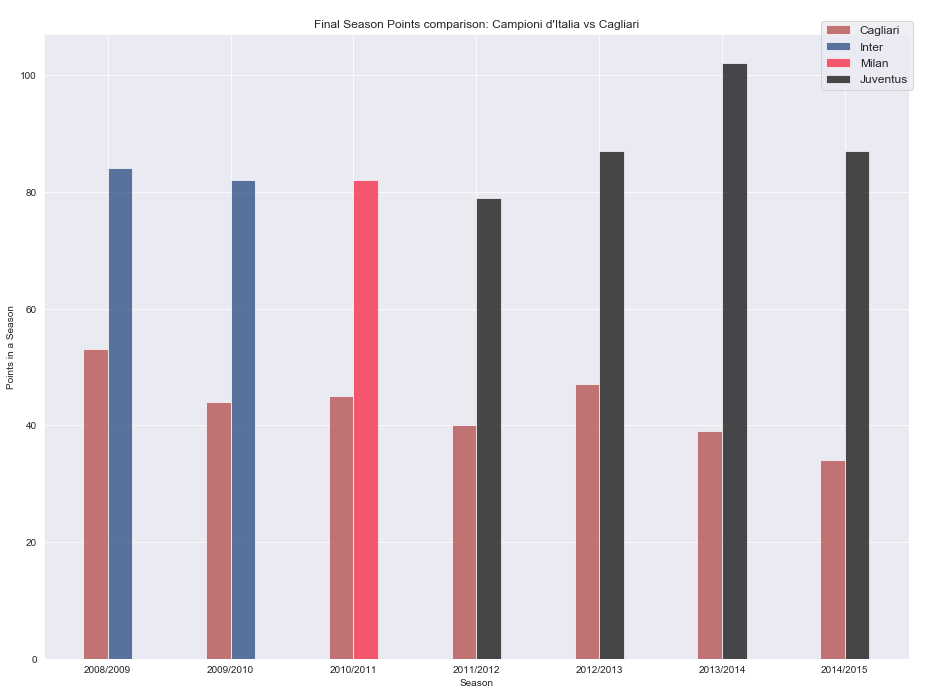

In [21]:
# total point for each season by team
cagliari_points = cagliari_match_stats.groupby('season').score.sum()
inter_points = inter_match_stats.groupby('season').score.sum()
milan_points = milan_match_stats.groupby('season').score.sum()
juventus_points = juventus_match_stats.groupby('season').score.sum()

# plot index by team
ind_cag = np.arange(0, 35, 5)
ind_int = np.arange(0, 10, 5)
ind_mil = np.arange(10, 15, 5)
ind_juv = np.arange(15, 35, 5)

#the width of the bars
width = 1

# title and labels
fig = plt.figure();
ax1 = plt.subplots(figsize=(15.5, 11.5));
fig.set_size_inches(14.5, 10.5);

# plot bars
cagliari_bar = plt.bar(ind_cag, cagliari_points, width, color='#B0413E', alpha=.7, label='Cagliari');
inter_bar = plt.bar(ind_int + 1, inter_points, width, color='#1B4079', alpha=.7, label='Inter');
milan_bar = plt.bar(ind_mil + 1 , milan_points, width, color='#F71735', alpha=.7, label='Milan');
juventus_bar = plt.bar(ind_juv +1, juventus_points, width, color='#000000', alpha=.7, label='Juventus');

labels = ['2008/2009', '2009/2010', '2010/2011', '2011/2012', '2012/2013', '2013/2014', '2014/2015']
plt.ylabel('Points in a Season');
plt.xlabel('Season');
plt.title('Final Season Points comparison: Campioni d\'Italia vs Cagliari');
locations = ind_cag + 0.5 # xtick locations
plt.xticks(locations, labels);

# legend
plt.legend(
    loc = 'best',
    prop={'size': 12},
    bbox_to_anchor=(0.88, 0.9),
    bbox_transform=fig.transFigure
);

As expected, in absolute terms there's always been a big difference. Cagliari (as available in the website <a href="https://www.risultati.it/calcio/italia/serie-a/archivio">Risultati.it</a>) reached its best result in the 2008/2009 (9th place), never a contender for the first place but it's clear a trend: the number of points at the end of the season has decreased year by year (with the exception of the 2012/2013) and this led to the relegation at the end of the 2014/2015 season.

### What makes the difference?

As we have seen, in numerical terms the chart shows that Cagliari has never been extremely competitive and where does this difference come from?

It's obvious, but the one who earns the most points... wins! So, let's see how many matches Cagliari won compared to the **Campioni d'Italia**

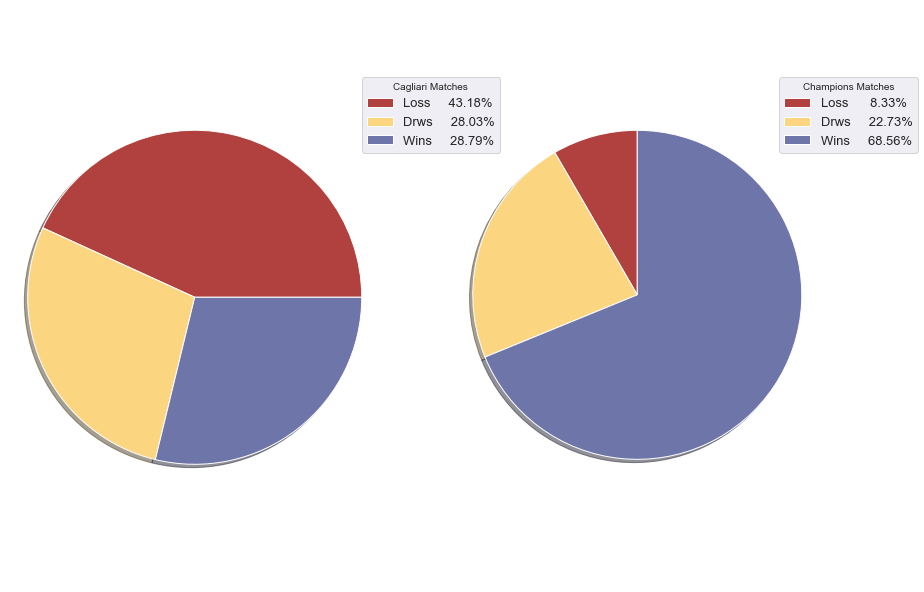

In [22]:
# counting Wins, Draws and Losses for Cagliari
results = cagliari_match_stats['score'].value_counts()
results = results.sort_index(0)
cagliari_results = pd.DataFrame({'results': results})

# Pct. for Each Result
pct_results = []
for index, value in cagliari_results.iterrows():
    pct_results.append(round((value['results']/results.sum()) * 100, 2))

cagliari_results['pct_res'] = pct_results

labels_cag = ["%s %9s%%" % (lab, siz) for lab, siz in zip(['Loss', 'Drws', 'Wins'], cagliari_results['pct_res'])]
 
# combining Wins, Draws and Losses for Cagliari
champions = inter_match_stats
champions = champions.append(milan_match_stats, ignore_index=True)
champions = champions.append(juventus_match_stats, ignore_index=True)
champions = champions['score'].value_counts()
champions = champions.sort_index(0)
champions_results = pd.DataFrame({'results': champions})

# Pct. for Each Result
pct_results = []
for index, value in champions_results.iterrows():
    pct_results.append(round((value['results']/results.sum()) * 100, 2))

champions_results['pct_res'] = pct_results

labels_champs = ["%s %9s%%" % (lab, siz) for lab, siz in zip(['Loss', 'Drws', 'Wins'], champions_results['pct_res'])]

# Plotting both pie charts
colors = ['#B0413E', '#FCD581', '#6E75A8']
explode = (0, 0, 0)
fig_win_loss = plt.figure()
fig_win_loss.set_size_inches(14.5, 10.5);

# Cagliari Pie Chart
ax_cag_win_loss = fig_win_loss.add_subplot(1,2,1)
plt.pie(cagliari_results['pct_res'], explode=explode, shadow=True, startangle=0, colors=colors, radius=1)
ax_cag_win_loss.axis('equal')

plt.legend(
    title = "Cagliari Matches",
    labels=labels_cag,
    loc = 'upper right',
    prop={'size': 13},
    bbox_to_anchor=(0.6, 0.8),
    bbox_transform=fig_win_loss.transFigure
);

# Champions Pie Chart
ax_champs_win_loss = fig_win_loss.add_subplot(1,2,2)
plt.pie(champions_results['pct_res'], explode=explode, shadow=True, startangle=90, colors=colors, radius=1)
ax_champs_win_loss.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


plt.legend(
    title = "Champions Matches",
    labels=labels_champs,
    loc = 'upper right',
    prop={'size': 13},
    bbox_to_anchor=(1.0, 0.8),
    bbox_transform=fig_win_loss.transFigure
);

Overall, above the 40% of the matches Cagliari played resulted in a defeat, while the Campioni d'Italia (combined) lost a little more than the 8% of their matches, collecting almost 70% of victories. 

Furthermore, as we said earlier, the Draws and Wins are basically the same amount so, even if Cagliari lost _a lot_ of matches, they also missed the chance to earn more points with *quite a lot* of draw matches.

How were these results distributed? How did Cagliari and Campioni d\'Italia perform in Home and Away matches? Is it true that, as expected, playing Home matches gives a little advantage?

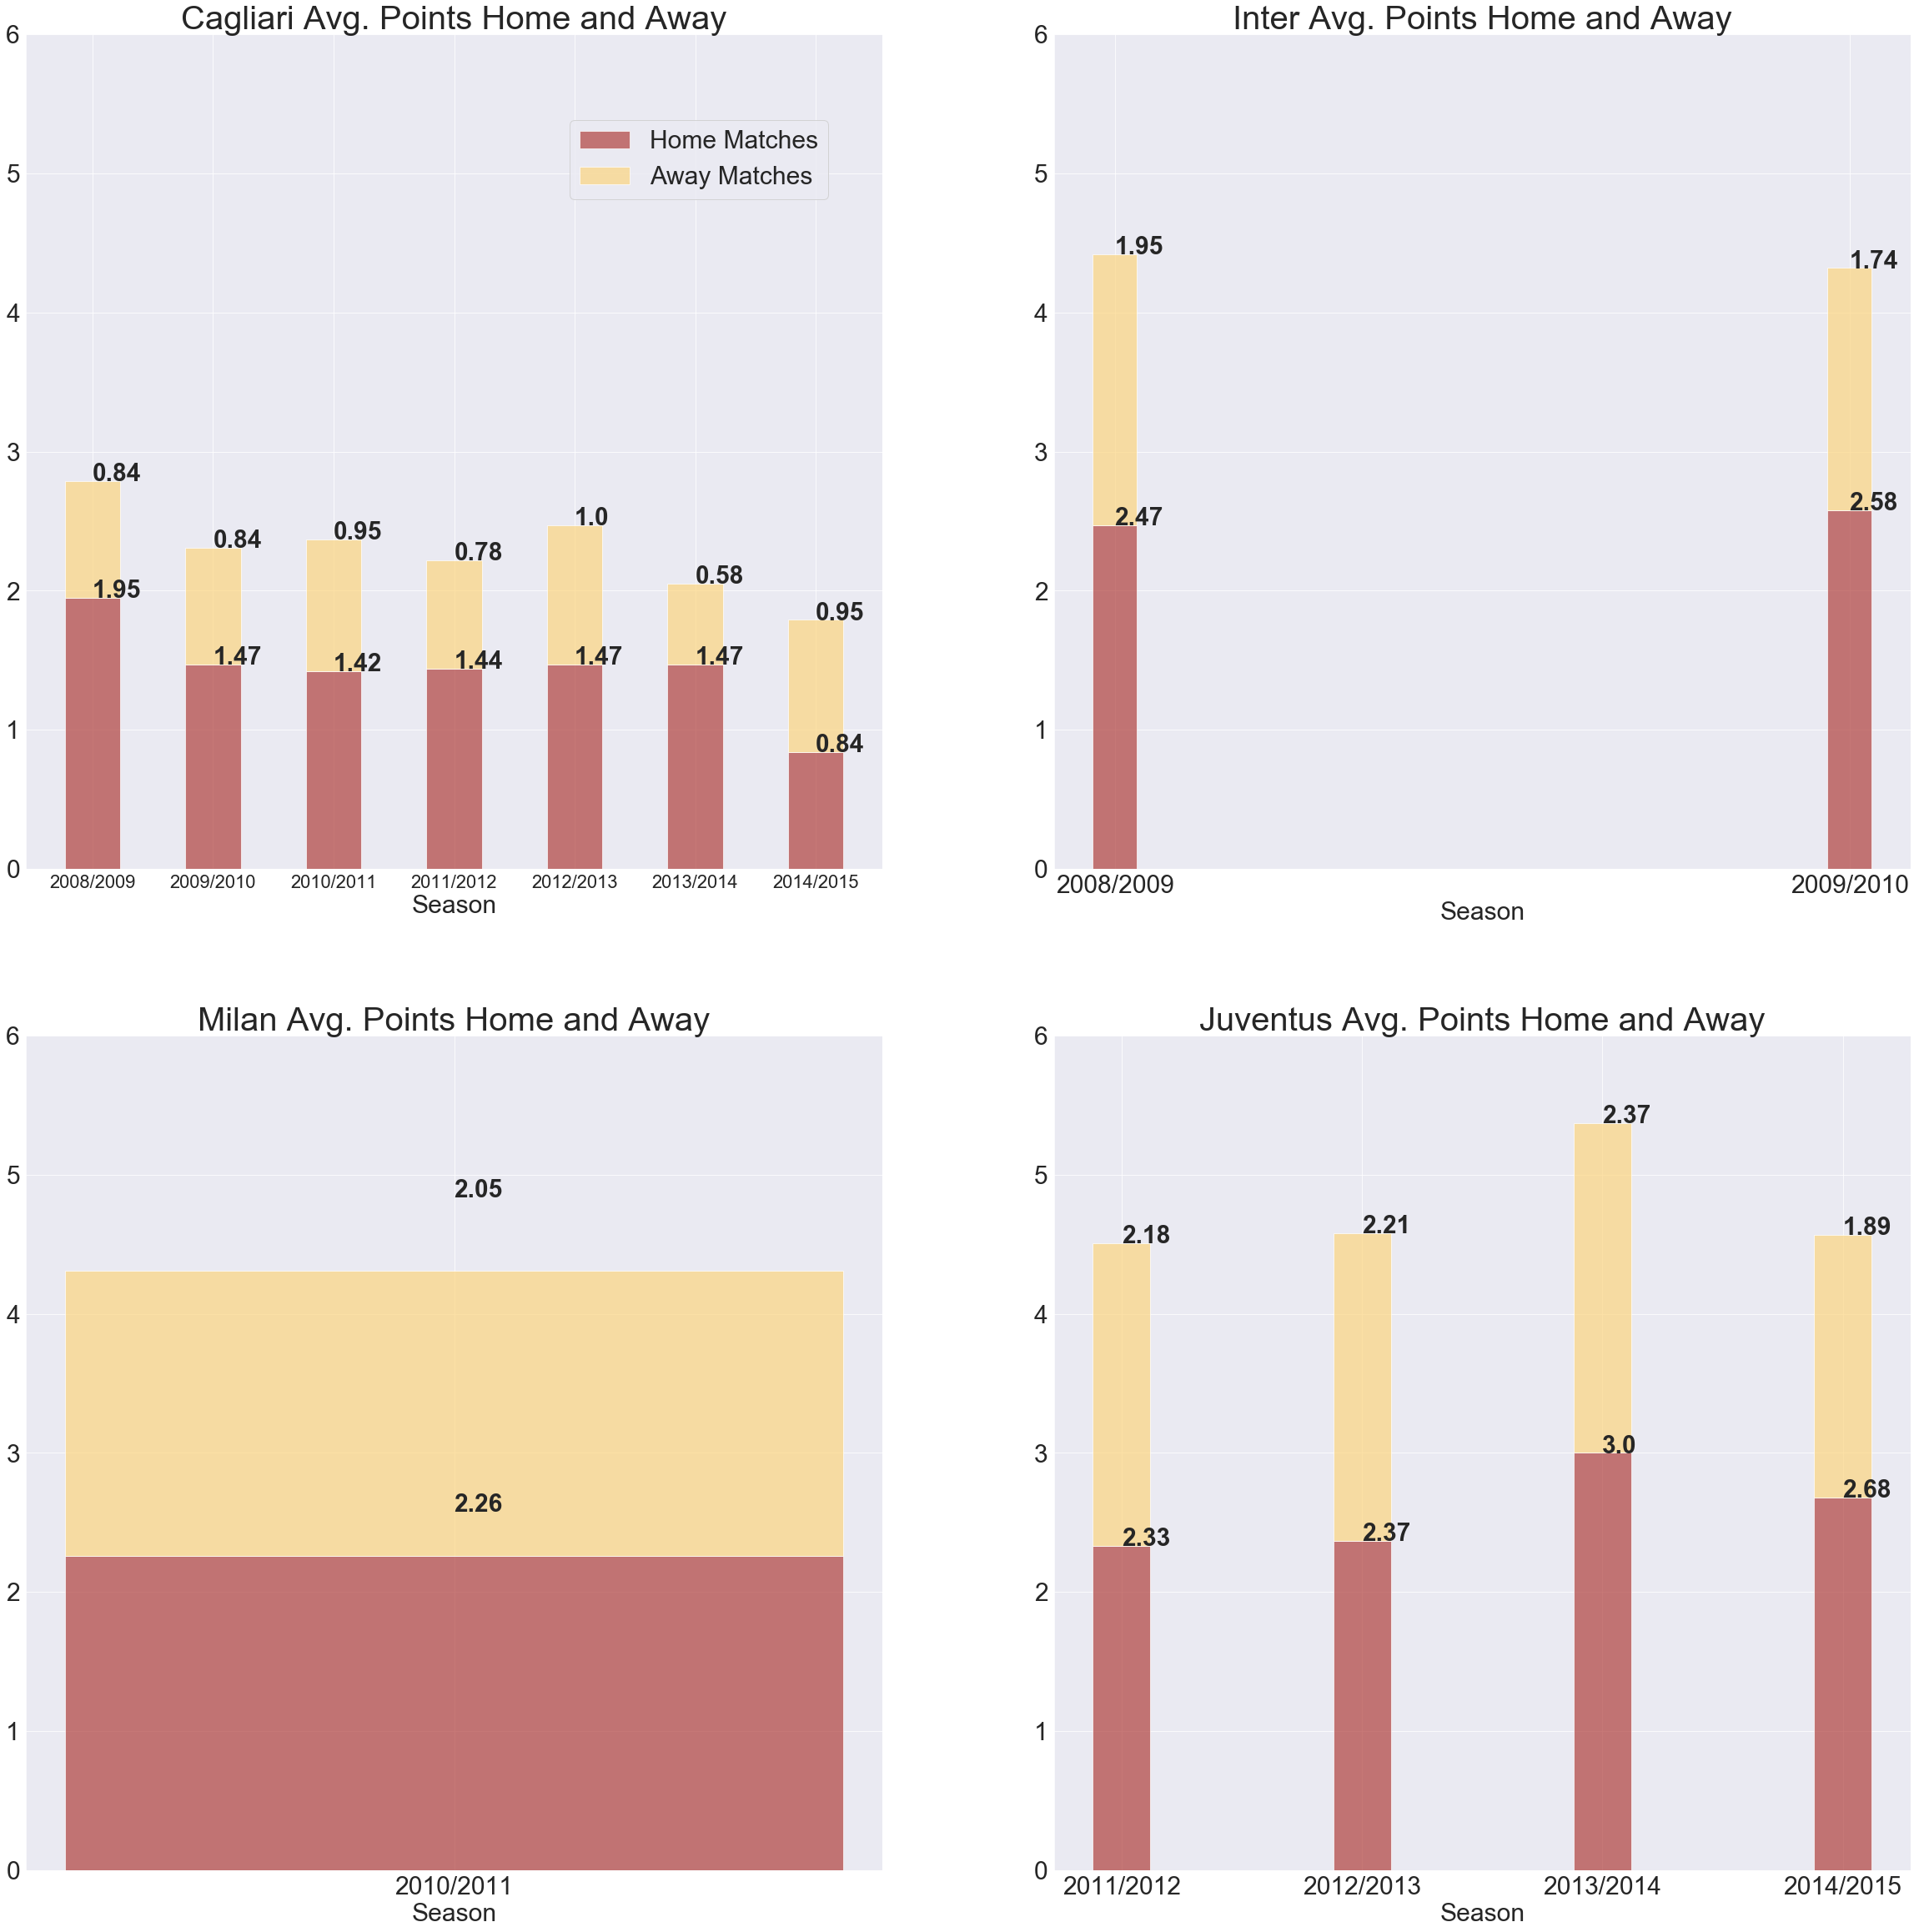

In [30]:
cag_home_points_avg = round(cagliari_match_stats.query('home_away == \'H\'').groupby('season').score.mean(), 2)
cag_away_points_avg = round(cagliari_match_stats.query('home_away == \'A\'').groupby('season').score.mean(), 2)

int_home_points_avg = round(inter_match_stats.query('home_away == \'H\'').groupby('season').score.mean(), 2)
int_away_points_avg = round(inter_match_stats.query('home_away == \'A\'').groupby('season').score.mean(), 2)

mil_home_points_avg = round(milan_match_stats.query('home_away == \'H\'').groupby('season').score.mean(), 2)
mil_away_points_avg = round(milan_match_stats.query('home_away == \'A\'').groupby('season').score.mean(), 2)

juv_home_points_avg = round(juventus_match_stats.query('home_away == \'H\'').groupby('season').score.mean(), 2)
juv_away_points_avg = round(juventus_match_stats.query('home_away == \'A\'').groupby('season').score.mean(), 2)


# Plotting home and away stacked barcharts
colors = ['#B0413E', '#FCD581', '#6E75A8']
cag_labels = ['2008/2009', '2009/2010', '2010/2011', '2011/2012', '2012/2013', '2013/2014', '2014/2015']
int_labels = ['2008/2009', '2009/2010']
mil_labels = ['2010/2011']
juv_labels = ['2011/2012', '2012/2013', '2013/2014', '2014/2015']
tot_points = np.arange(0,7) # from 0 to 6, because it's impossible to get more than 6 points

# plot index by team
ind_cag = np.arange(0, 35, 5)
ind_int = np.arange(0, 10, 5)
ind_mil = np.arange(0, 5, 5)
ind_juv = np.arange(0, 20, 5)

# I create a Figure and a set of subplots (a matrix of 2 rows by 2 cols)
fig_home_away_avg, axarr = plt.subplots(2, 2)
fig_home_away_avg.set_size_inches(40.5, 40.5);


# Cagliari Chart
plt.sca(axarr[0, 0]) # Cagliari goes in the first row, top left square: coordinates 0, 0
ax_cag_win_loss = fig_home_away_avg.add_subplot(axarr[0, 0])
width = 2.3
plt.bar(ind_cag, cag_home_points_avg, width, color='#B0413E', alpha=.7, label=cag_labels);
plt.bar(ind_cag, cag_away_points_avg, width, color='#FCD581', alpha=.7, label=cag_labels,  bottom=cag_home_points_avg)

plt.xlabel('Season', fontsize=30);
plt.title('Cagliari Avg. Points Home and Away', fontsize=40);
locations = ind_cag
plt.xticks(locations, cag_labels);
plt.yticks(tot_points, tot_points)
plt.tick_params(axis='y', which='major', labelsize=30)
plt.tick_params(axis='x', which='major', labelsize=22)
for i,j in enumerate(cag_away_points_avg):
    ax_cag_win_loss.text(ind_cag[i],j + cag_home_points_avg[i],str(j), weight = "bold", fontsize=30)
for i, j in enumerate(cag_home_points_avg):    
    ax_cag_win_loss.text(ind_cag[i], j, str(j), weight = "bold", fontsize=30)



# Inter Chart
plt.sca(axarr[0, 1])
ax_int_win_loss = fig_home_away_avg.add_subplot(axarr[0, 1])
width = 0.3

plt.bar(ind_int, int_home_points_avg, width, color='#B0413E', alpha=.7, label=int_labels);
plt.bar(ind_int, int_away_points_avg, width, color='#FCD581', alpha=.7, label=int_labels,  bottom=int_home_points_avg)

plt.xlabel('Season', fontsize=30);
plt.title('Inter Avg. Points Home and Away', fontsize=40);
locations = ind_int
plt.xticks(locations, int_labels);
plt.yticks(tot_points, tot_points)
plt.tick_params(axis='both', which='major', labelsize=30)
for i,j in enumerate(int_away_points_avg):
    ax_int_win_loss.text(ind_int[i],j + int_home_points_avg[i],str(j), weight = "bold", fontsize=30)
for i, j in enumerate(int_home_points_avg):    
    ax_int_win_loss.text(ind_int[i], j, str(j), weight = "bold", fontsize=30)


# Milan Chart
plt.sca(axarr[1, 0])
ax_mil_win_loss = fig_home_away_avg.add_subplot(axarr[1, 0])
plt.bar(ind_mil, mil_home_points_avg, width, color='#B0413E', alpha=.7, label=mil_labels);
plt.bar(ind_mil, mil_away_points_avg, width, color='#FCD581', alpha=.7, label=mil_labels,  bottom=mil_home_points_avg)

plt.xlabel('Season', fontsize=30);
plt.title('Milan Avg. Points Home and Away', fontsize=40);
locations = ind_mil
plt.xticks(locations, mil_labels);
plt.yticks(tot_points, tot_points)
plt.tick_params(axis='both', which='major', labelsize=30)

ax_mil_win_loss.text(ind_mil[0],j,str(mil_home_points_avg['2010/2011']), weight = "bold", fontsize=30)
ax_mil_win_loss.text(ind_mil[0],j + mil_home_points_avg['2010/2011'],str(mil_away_points_avg['2010/2011']), weight = "bold", fontsize=30)


# Juventus Chart
plt.sca(axarr[1, 1])
ax_juv_win_loss = fig_home_away_avg.add_subplot(axarr[1, 1])
width = 1.2
plt.bar(ind_juv, juv_home_points_avg, width, color='#B0413E', alpha=.7, label=juv_labels);
plt.bar(ind_juv, juv_away_points_avg, width, color='#FCD581', alpha=.7, label=juv_labels,  bottom=juv_home_points_avg)
#plt.ylabel('Avg. Points Home/Away', fontsize=30);
plt.xlabel('Season', fontsize=30);
plt.title('Juventus Avg. Points Home and Away', fontsize=40);
locations = ind_juv
plt.xticks(locations, juv_labels);
plt.yticks(tot_points, tot_points)
plt.tick_params(axis='both', which='major', labelsize=30)
for i,j in enumerate(juv_away_points_avg):
    ax_juv_win_loss.text(ind_juv[i],j + juv_home_points_avg[i],str(j), weight = "bold", fontsize=30)
for i, j in enumerate(juv_home_points_avg):    
    ax_juv_win_loss.text(ind_juv[i], j, str(j), weight = "bold", fontsize=30)
    
plt.legend(
    labels=['Home Matches', 'Away Matches'],
    loc = 'upper right',
    prop={'size': 30},
    bbox_to_anchor=(0.46, 0.85),
    bbox_transform=fig_home_away_avg.transFigure
);    

The results of Cagliari are strongly unbalanced towards better Home performances (the season 2008/2009 had almost 2 Home points per game) while Away matches have usually been quite stingy with satisfactions (1ppg as best in the 2012/2013 season and 0,5 ppg the following season as worst performance).

Campioni d'Italia have more balanced results between Home and Away matches: Away matches averages have never been below 1.74 points (Inter 2009/2010) per match and Home matches have always granted at least 2 points (usually never less than 2.26 points, with an astonishing 3 points per match for Juventus in the record-setting 2013/2014 season. All the matches played at home resulted in a victory!)

### How to get a win?

As expected, performances were much superior for the Champions. Cagliari lost many points along the way: Home matches average points has been "competitive" only in the 2008/2009 season (where the difference was just 0.52 points favorable to Inter) while Away matches average has always been quite bad (and in the 2013/2014 it became a *tragedy*: Juventus recorded an average over 4 times higher than Cagliari's).


Why such poor performances? In football/soccer, you earn points by scoring goals (and, maybe most important, by getting the least possible). How did Cagliari perform during the years?

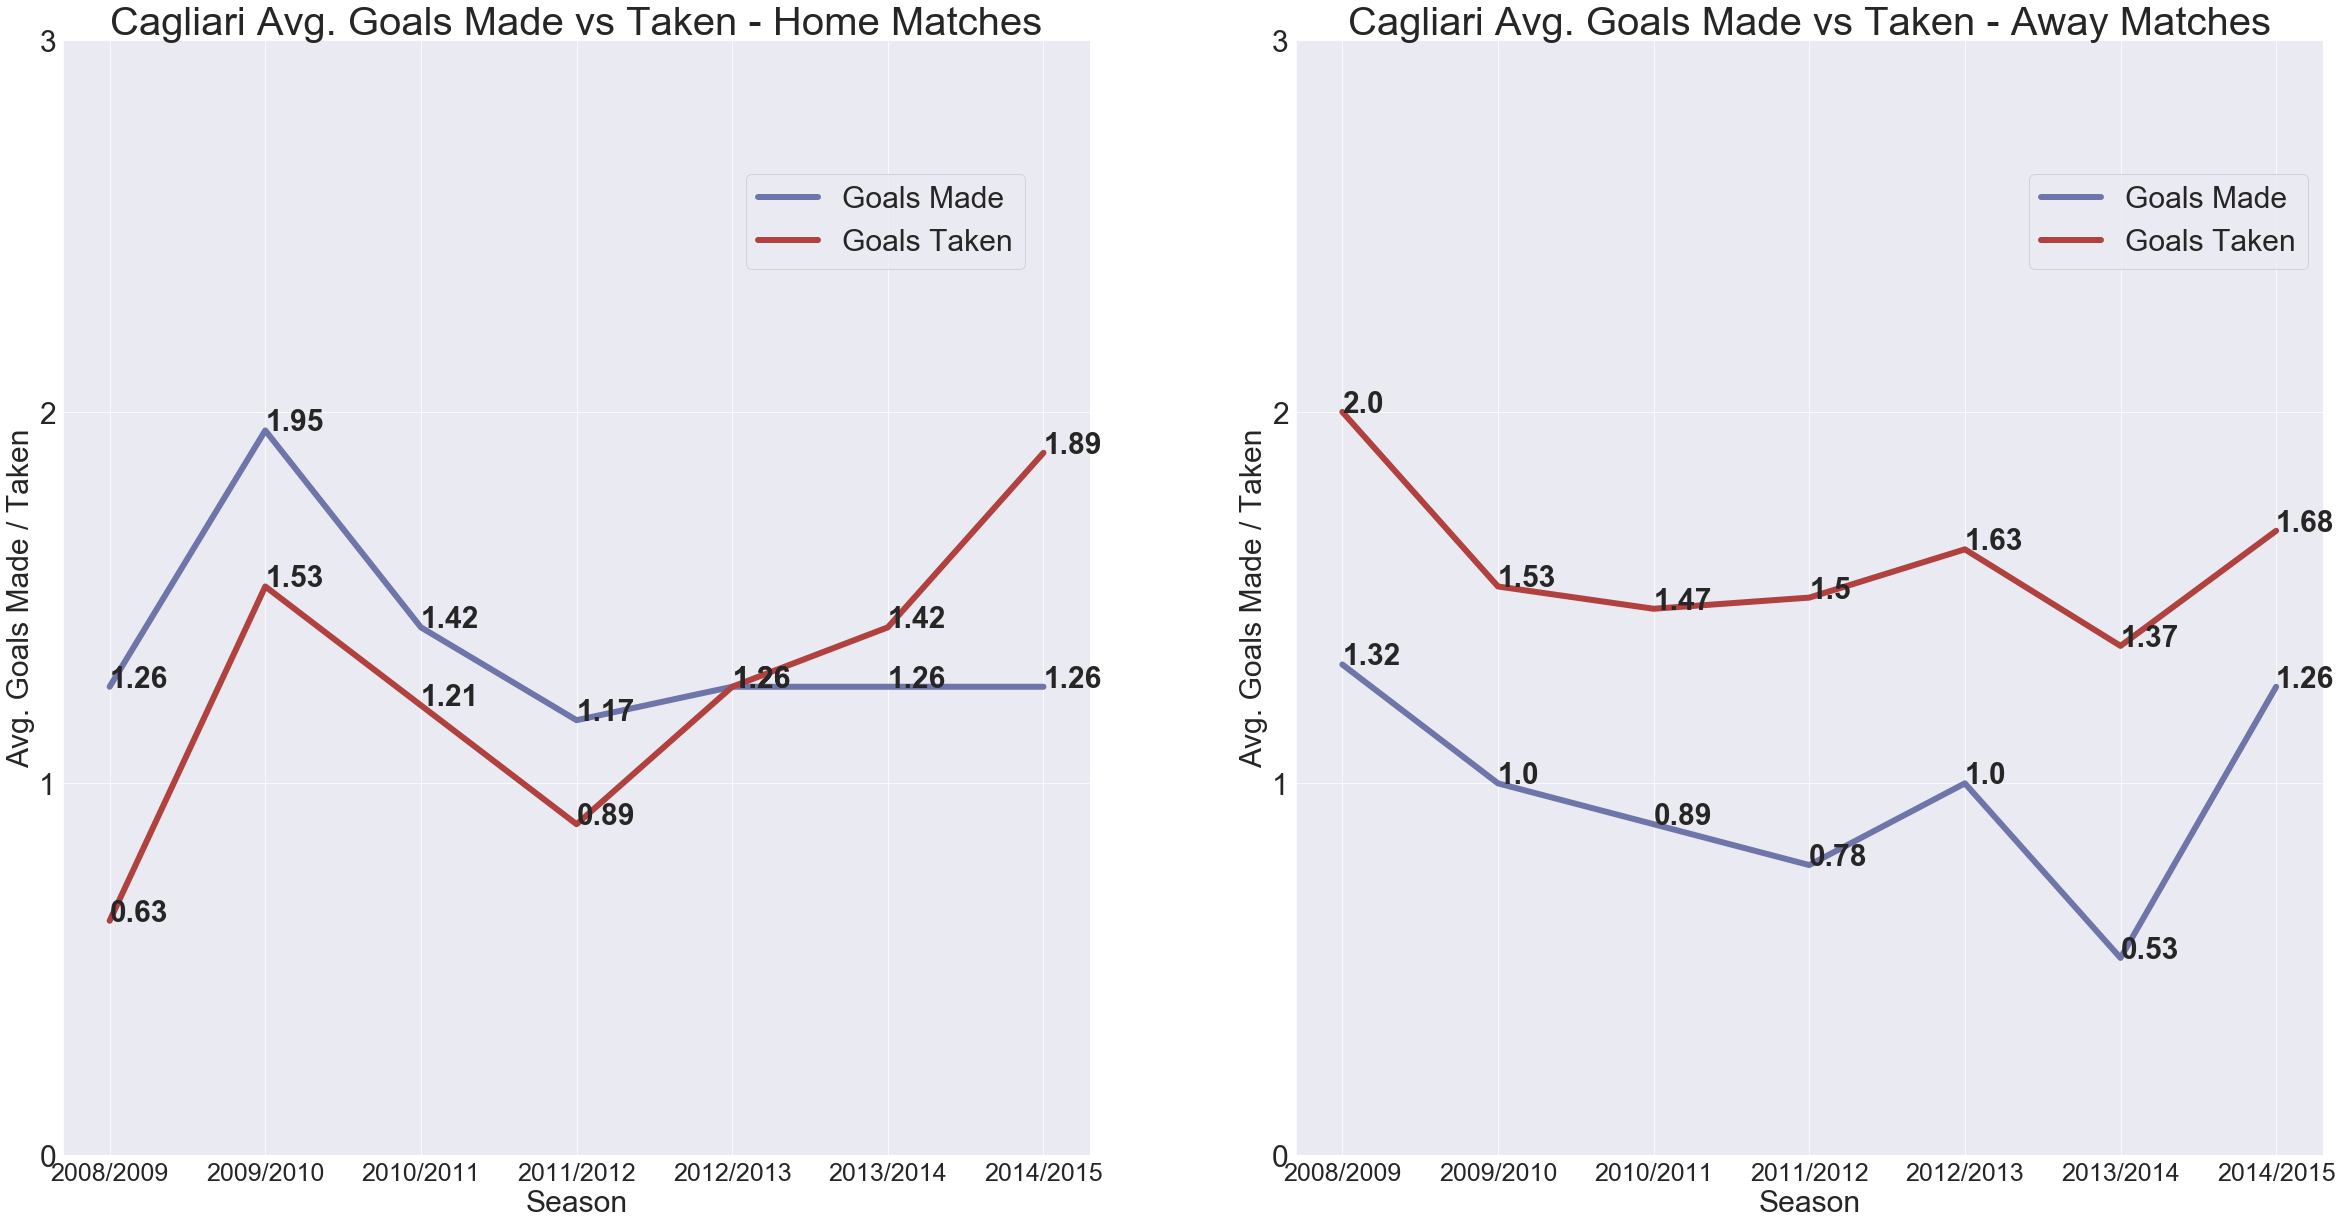

In [31]:
cagliari_match_stats.groupby('season').agg({'home_team_goal':'sum', 'away_team_goal': 'sum'})

cag_home_goals_made_avg = round(cagliari_match_stats.query('home_away == \'H\'').groupby('season').home_team_goal.mean(), 2)
cag_home_goals_taken_avg = round(cagliari_match_stats.query('home_away == \'H\'').groupby('season').away_team_goal.mean(), 2)
cag_away_goals_made_avg = round(cagliari_match_stats.query('home_away == \'A\'').groupby('season').away_team_goal.mean(), 2)
cag_away_goals_taken_avg = round(cagliari_match_stats.query('home_away == \'A\'').groupby('season').home_team_goal.mean(), 2)


avg_goals2 = np.arange(4)
fig_cag_goals2, axarr = plt.subplots(1, 2)
fig_cag_goals2.set_size_inches(40.5, 20.5);

# Cagliari Home Chart
plt.sca(axarr[0])
ax_cag_home_goals = fig_cag_goals2.add_subplot(axarr[0])
plt.plot(ind_cag, cag_home_goals_made_avg, color='#6E75A8', alpha=1, label="Goals Made", linewidth=6);
plt.plot(ind_cag, cag_home_goals_taken_avg, color='#B0413E', alpha=1, label="Goals Taken", linewidth=6);
plt.ylabel('Avg. Goals Made / Taken', fontsize=30);
plt.xlabel('Season', fontsize=30);
plt.title('Cagliari Avg. Goals Made vs Taken - Home Matches', fontsize=40);
locations = ind_cag
plt.xticks(locations, cag_labels);
plt.yticks(avg_goals2, avg_goals2)
plt.tick_params(axis='y', which='major', labelsize=30)
plt.tick_params(axis='x', which='major', labelsize=25)
for i,j in enumerate(cag_home_goals_made_avg):
    ax_cag_home_goals.text(ind_cag[i],j,str(j), weight = "bold", fontsize=30)
for i, j in enumerate(cag_home_goals_taken_avg):    
    ax_cag_home_goals.text(ind_cag[i], j, str(j), weight = "bold", fontsize=30)

# legend
ax_cag_home_goals.legend(
    loc = 'best',
    prop={'size': 30},
    bbox_to_anchor=(0.46, 0.8),
    bbox_transform=fig_cag_goals2.transFigure
);
    
    
    
    
# Cagliari Away Chart
plt.sca(axarr[1])
ax_cag_away_goals = fig_cag_goals2.add_subplot(axarr[1])
plt.plot(ind_cag, cag_away_goals_made_avg, color='#6E75A8', alpha=1, label="Goals Made", linewidth=6);
plt.plot(ind_cag, cag_away_goals_taken_avg, color='#B0413E', alpha=1, label="Goals Taken", linewidth=6);
plt.ylabel('Avg. Goals Made / Taken', fontsize=30);
plt.xlabel('Season', fontsize=30);
plt.title('Cagliari Avg. Goals Made vs Taken - Away Matches', fontsize=40);
locations = ind_cag
plt.xticks(locations, cag_labels);
plt.yticks(avg_goals2, avg_goals2)
plt.tick_params(axis='y', which='major', labelsize=30)
plt.tick_params(axis='x', which='major', labelsize=25)
for i,j in enumerate(cag_away_goals_made_avg):
    ax_cag_away_goals.text(ind_cag[i],j,str(j), weight = "bold", fontsize=30)
for i, j in enumerate(cag_away_goals_taken_avg):    
    ax_cag_away_goals.text(ind_cag[i], j, str(j), weight = "bold", fontsize=30)
    
# legend
ax_cag_away_goals.legend(
    loc = 'best',
    prop={'size': 30},
    bbox_to_anchor=(0.9, 0.8),
    bbox_transform=fig_cag_goals2.transFigure
);

Home goals made have always been quite constant and, actually, at Home Cagliari kept a constant ppg average for 5 seasons in a row which would sound as a good result for such a small team in such a competitive championship (ok, not exactly an average which would lead to the final victory anyway... but we're a small team!) this can be translated into a "we have a safe port from which earn points".

But, remembering the decreasing trend in the final season points, this trend can be explained by the Away matches performances, which have been an unknown: the average ppg (and goals per match) went up and down like in a rollercoaster.

But what probably explains the decreasing trend in points and the relegation at the end of the 2014/2015 season the most is: defensive performances. If home goals made have been (again) a constant, defensive performance has been worse season after season and in the 2014/2015 the 1.89 Home goals taken per match lead to a very poor 0.84 ppg (lower than the away matches ppg) average. Cagliari, we had a problem!

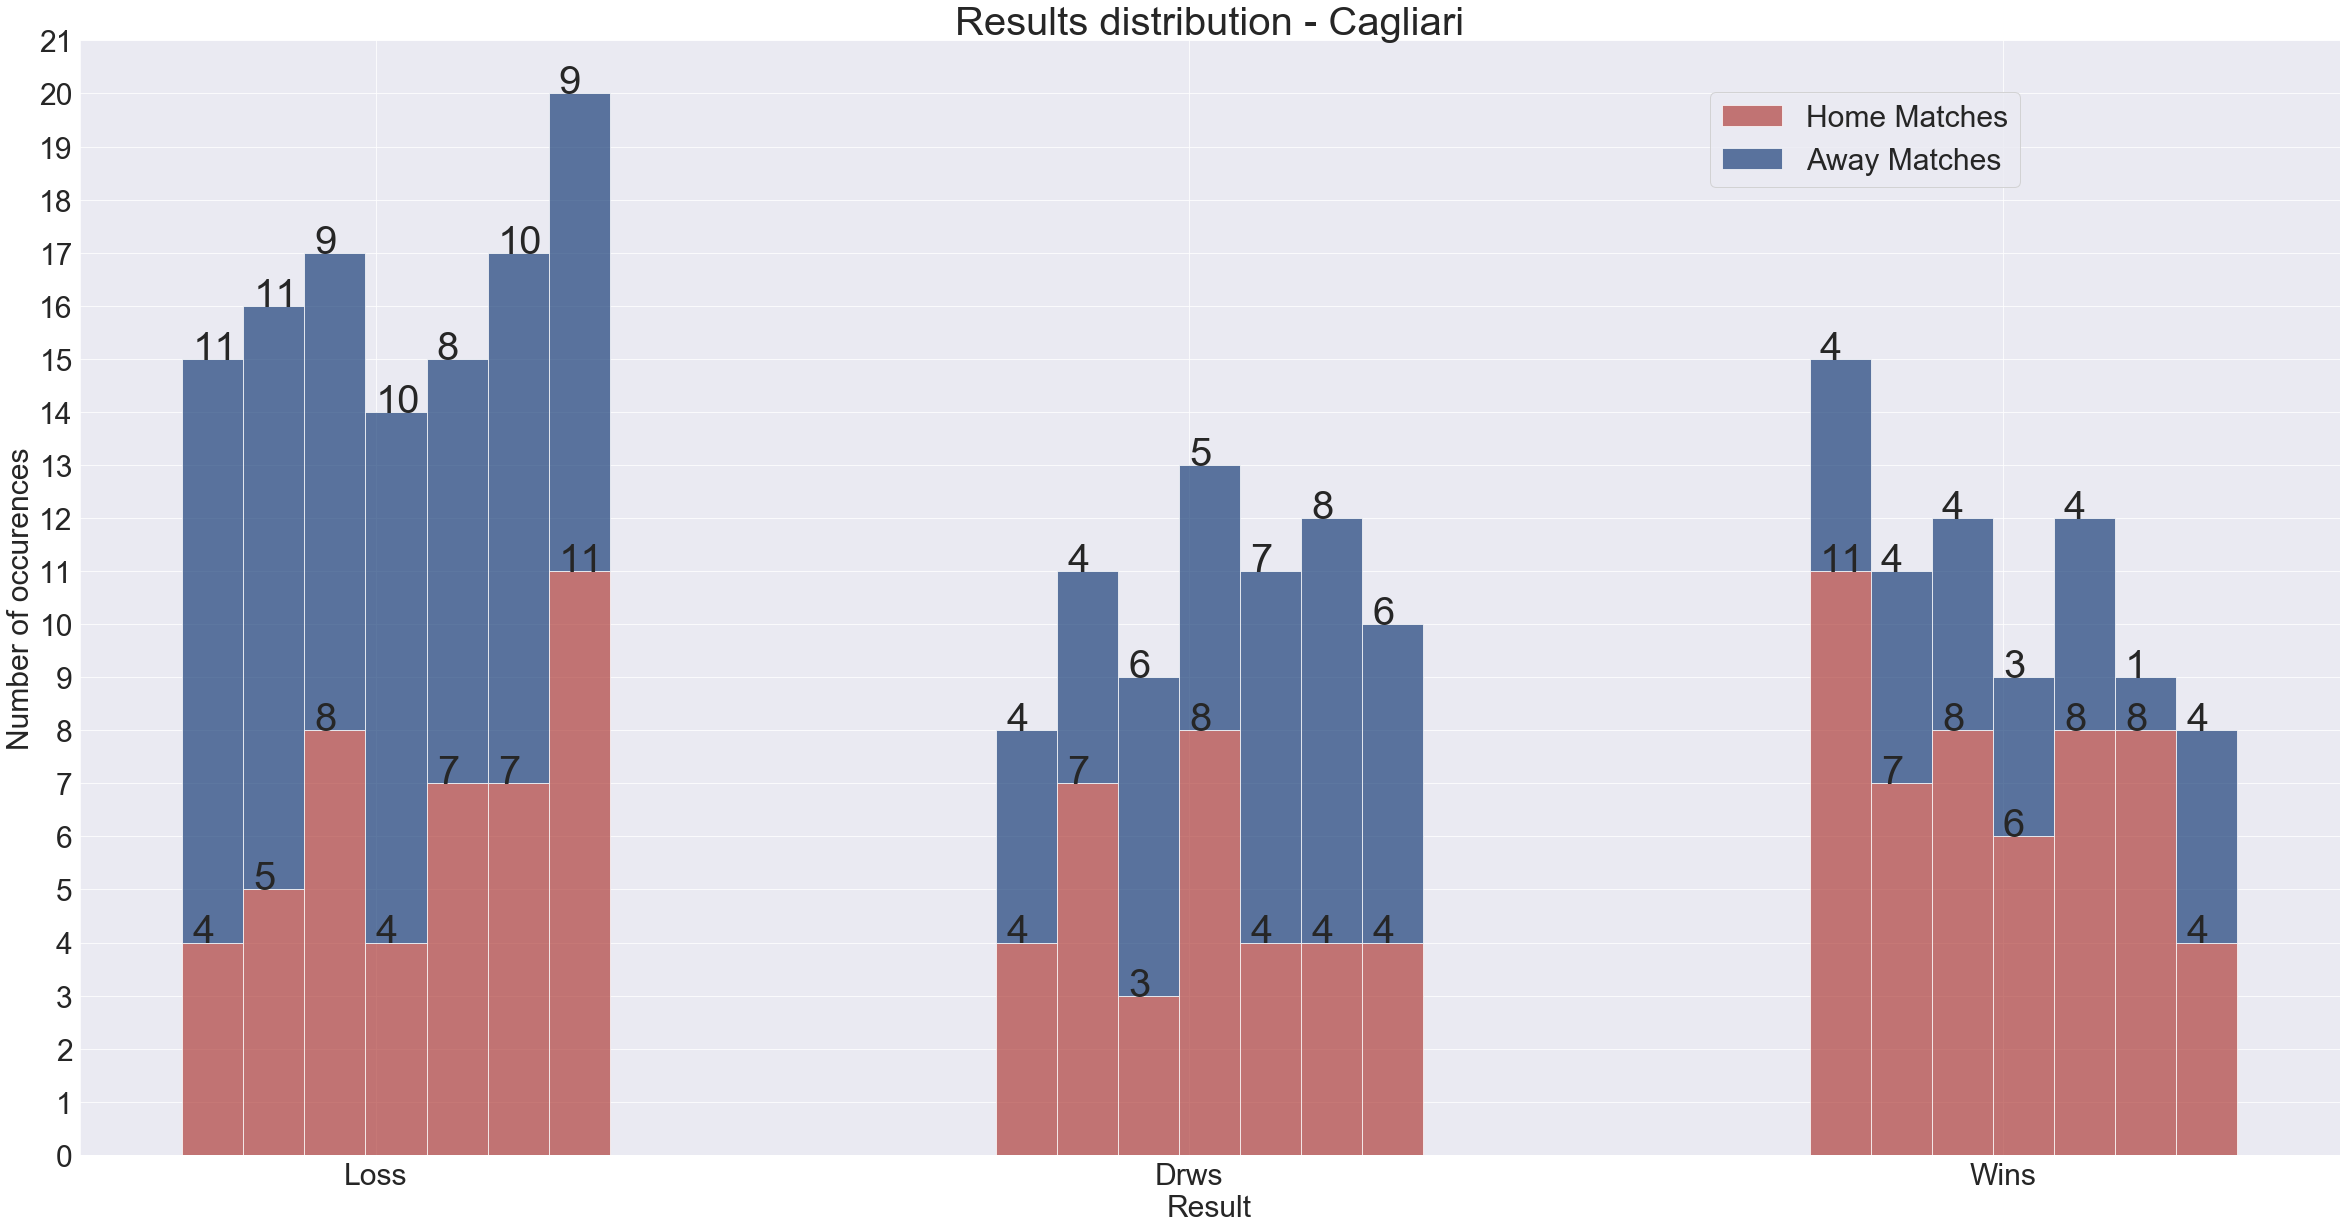

In [69]:
xticks = ['Loss', 'Drws', 'Wins']
ind = np.arange(0, 10, 4)

fig_tot_res = plt.figure()
ax_tot_results = fig_tot_res.add_subplot(1, 1, 1)
fig_tot_res.set_size_inches(40.5, 20.5);

y = np.arange(22)
width = 0.3

step = []
plt.bar(ind, results['2008/2009']['H'], width, alpha=.7, color='#B0413E', label='Home Results');
for i, j in enumerate(results['2008/2009']['H']):
    ax_tot_results.text(ind[i] - 0.1, int(j), str(j), fontsize=40)
    step.append(j)
    
plt.bar(ind, results['2008/2009']['A'], width, alpha=.7, color='#1B4079', label='Home Results', bottom= results['2008/2009']['H']);
for i, j in enumerate(results['2008/2009']['A']):
    ax_tot_results.text(ind[i] - 0.1, int(j) + step[i], str(j), fontsize=40)    

step = []
plt.bar(ind+0.3, results['2009/2010']['H'], width, alpha=.7, color='#B0413E', label='Home Results');
for i, j in enumerate(results['2009/2010']['H']):
    ax_tot_results.text(ind[i]+0.2, int(j), str(j), fontsize=40)
    step.append(j)

plt.bar(ind+0.3, results['2009/2010']['A'], width, alpha=.7, color='#1B4079', bottom= results['2009/2010']['H'], label='Away Results');
for i, j in enumerate(results['2009/2010']['A']):
    ax_tot_results.text(ind[i]+0.2, int(j) + step[i], str(j), fontsize=40)

step = []
plt.bar(ind+0.6, results['2010/2011']['H'], width, alpha=.7, color='#B0413E', label='Home Results');
for i, j in enumerate(results['2010/2011']['H']):
    ax_tot_results.text(ind[i]+0.5, int(j), str(j), fontsize=40)
    step.append(j)

plt.bar(ind+0.6, results['2010/2011']['A'], width, alpha=.7, color='#1B4079', bottom= results['2010/2011']['H'], label='Away Results');
for i, j in enumerate(results['2010/2011']['A']):
    ax_tot_results.text(ind[i]+0.5, int(j) + step[i], str(j), fontsize=40)
    
step = []
plt.bar(ind+0.9, results['2011/2012']['H'], width, alpha=.7, color='#B0413E', label='Home Results');
for i, j in enumerate(results['2011/2012']['H']):
    ax_tot_results.text(ind[i]+0.8, int(j), str(j), fontsize=40)
    step.append(j)

plt.bar(ind+0.9, results['2011/2012']['A'], width, alpha=.7, color='#1B4079', bottom= results['2011/2012']['H'], label='Away Results');
for i, j in enumerate(results['2011/2012']['A']):
    ax_tot_results.text(ind[i]+0.8, int(j) + step[i], str(j), fontsize=40)

step = []
plt.bar(ind+1.2, results['2012/2013']['H'], width, alpha=.7, color='#B0413E', label='Home Results');
for i, j in enumerate(results['2012/2013']['H']):
    ax_tot_results.text(ind[i]+1.1, int(j), str(j), fontsize=40)
    step.append(j)

plt.bar(ind+1.2, results['2012/2013']['A'], width, alpha=.7, color='#1B4079', bottom= results['2012/2013']['H'], label='Away Results');
for i, j in enumerate(results['2012/2013']['A']):
    ax_tot_results.text(ind[i]+1.1, int(j) + step[i], str(j), fontsize=40)

step = []
plt.bar(ind+1.5, results['2013/2014']['H'], width, alpha=.7, color='#B0413E', label='Home Results');
for i, j in enumerate(results['2013/2014']['H']):
    ax_tot_results.text(ind[i]+1.4, int(j), str(j), fontsize=40)
    step.append(j)

plt.bar(ind+1.5, results['2013/2014']['A'], width, alpha=.7, color='#1B4079', bottom= results['2013/2014']['H'], label='Away Results');
for i, j in enumerate(results['2013/2014']['A']):
    ax_tot_results.text(ind[i]+1.4, int(j) + step[i], str(j), fontsize=40)
    
step = []
plt.bar(ind+1.8, results['2014/2015']['H'], width, alpha=.7, color='#B0413E', label='Home Results');
for i, j in enumerate(results['2014/2015']['H']):
    ax_tot_results.text(ind[i]+1.7, int(j), str(j), fontsize=40)
    step.append(j)

plt.bar(ind+1.8, results['2014/2015']['A'], width, alpha=.7, color='#1B4079', bottom= results['2014/2015']['H'], label='Away Results');
for i, j in enumerate(results['2014/2015']['A']):
    ax_tot_results.text(ind[i]+1.7, int(j) + step[i], str(j), fontsize=40)
    
    
plt.xticks(ind + 0.8, xticks);
plt.yticks(y, y);
plt.ylabel('Number of occurences', fontsize=30);
plt.xlabel('Result', fontsize=30);

qualcosa = ['2008/2009', '2009/2010', '2010/2011', '2011/2012', '2012/2013', '2013/2014', '2014/2015']

plt.tick_params(axis='both', which='major', labelsize=30);
plt.title('Results distribution - Cagliari', fontsize=40);   

# legend
plt.legend(
    labels = ['Home Matches', 'Away Matches'],
    loc = 'best',
    prop={'size': 30},
    bbox_to_anchor=(4.71, 4),
    bbox_transform=fig.transFigure
);    

The barplot above shows the distribution of results (the leftmost bar are the Losses/Draws/Wins of the 2008/2009 season moving rightwards until the 2014/2015 season).

The number of total defeats (except for the 2011/2012 season) has been quite constant (not less than 15 each year except 1 season) and in the last 4 seasons the trend was of growth (with the record of 20 defeats in 38 matches... sigh!).

Draws are not very constant in the total number but in general the trend is growing and it's clear that the number of away draw matches is growing (this is the sympthom of not very productive strikers, with the team playing away matches just hoping not to get any goals).

The total number of wins is, obviously, in a decreasing trend. But while the Home wins between 2009/2010 and 2013/2014 are almost constant (it's the away matches number which makes the difference, and in 2012/2013 the high number of draw matches) the last season records half of the home victories compared to the past and the missing wins turned into defeats (the number of home draws was exactly the same the last 3 seasons).

That lead to the relegation.

<a id='conclusions'></a>
## Conclusions

In a competitive world like professional sports, it's obvious that availing of the best players and the best training methodologies is extremely important for the final result (as you can see, the 3 teams to win the championship are probably the 3 most important teams in Italy). So, money matters.

But checking the final results that Cagliari recorded over the years, it's clear that the team has not evolved but has been involved.

This database has been, luckily, complete and no missing data or duplicated records were detected that could have somehow negatively influenced the results. The only intervention was to convert the match dates into datetime fields, they were recorded as strings.

Talking about results, the number of total defeats (over 43% in 264 matches versus 8% for the combined Campioni d'Italia) and the decreasing trend in the number of victories shows (along with the scary trend in number of goals in home matches) that if you do not try to actively pursue the victory (see the growing trend in draw matches, especially in away matches) nothing good comes on its own.

If you do not score goals, you do not win matches for sure! For 3 years in a row, the Home goals average has been stuck while the away goals average (with the exception of the "crazy" last season) was in a decreasing trend (with the embarrassing 0.53 goals per matches average in 2013/2014).

If to all this you sum up an easily penetrable defense... the disaster arrives! 

So, in order to win championships or being competitive at least, a team should be more dangerous in the offensive phase and make it very hard to its opponents to score goals.
(To those who follow football, the Italian National team is renowed for not scoring too many goals but our strikers used to score when it was really important and the amazing defenders we used to have in the past, made it possible to protect the advantage and win 4 World Titles and 1 European Title as well... and this is exactly what Cagliari has missed in the last seasons!).

After the relegation, anyway, Cagliari returned to Serie A after just one year of Serie B and we are still alive and kicking!.

**Fortza Casteddu!**

<img src='cagliari_calcio.png' width='350px' height='350px'>